## Wrapper Methods

In this project, you'll analyze data from a survey conducted by Fabio Mendoza Palechor and Alexis de la Hoz Manotas that asked people about their eating habits and weight. The data was obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+). Categorical variables were changed to numerical ones in order to facilitate analysis.

First, you'll fit a logistic regression model to try to predict whether survey respondents are obese based on their answers to questions in the survey. After that, you'll use three different wrapper methods to choose a smaller feature subset.

You'll use sequential forward selection, sequential backward floating selection, and recursive feature elimination. After implementing each wrapper method, you'll evaluate the model accuracy on the resulting smaller feature subsets and compare that with the model accuracy using all available features.

In [317]:
# Import libraries
import pandas as pd
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
%matplotlib inline
%matplotlib widget

## Evaluating a Logistic Regression Model

The data set `obesity` contains 18 predictor variables. Here's a brief description of them.

* `Gender` is `1` if a respondent is male and `0` if a respondent is female.
* `Age` is a respondent's age in years.
* `family_history_with_overweight` is `1` if a respondent has family member who is or was overweight, `0` if not.
* `FAVC` is `1` if a respondent eats high caloric food frequently, `0` if not.
* `FCVC` is `1` if a respondent usually eats vegetables in their meals, `0` if not.
* `NCP` represents how many main meals a respondent has daily (`0` for 1-2 meals, `1` for 3 meals, and `2` for more than 3 meals).
* `CAEC` represents how much food a respondent eats between meals on a scale of `0` to `3`.
* `SMOKE` is `1` if a respondent smokes, `0` if not.
* `CH2O` represents how much water a respondent drinks on a scale of `0` to `2`.
* `SCC` is `1` if a respondent monitors their caloric intake, `0` if not.
* `FAF` represents how much physical activity a respondent does on a scale of `0` to `3`.
* `TUE` represents how much time a respondent spends looking at devices with screens on a scale of `0` to `2`.
* `CALC` represents how often a respondent drinks alcohol on a scale of `0` to `3`.
* `Automobile`, `Bike`, `Motorbike`, `Public_Transportation`, and `Walking` indicate a respondent's primary mode of transportation. Their primary mode of transportation is indicated by a `1` and the other columns will contain a `0`.

The outcome variable, `NObeyesdad`, is a `1` if a patient is obese and a `0` if not.

Use the `.head()` method and inspect the data.

In [318]:
# https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+

# Load the data
obesity = pd.read_csv("obesity.csv")

# Inspect the data
obesity.head(-10)

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,Automobile,Bike,Motorbike,Public_Transportation,Walking,NObeyesdad
0,0,21.000000,1,0,2.0,3.0,1,0,2.000000,0,0.000000,1.000000,0,0,0,0,1,0,0
1,0,21.000000,1,0,3.0,3.0,1,1,3.000000,1,3.000000,0.000000,1,0,0,0,1,0,0
2,1,23.000000,1,0,2.0,3.0,1,0,2.000000,0,2.000000,1.000000,2,0,0,0,1,0,0
3,1,27.000000,0,0,3.0,3.0,1,0,2.000000,0,2.000000,0.000000,2,0,0,0,0,1,0
4,1,22.000000,0,0,2.0,1.0,1,0,2.000000,0,0.000000,0.000000,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,0,25.955014,1,1,3.0,3.0,1,0,2.094901,0,0.070890,0.599441,1,0,0,0,1,0,1
2097,0,25.996716,1,1,3.0,3.0,1,0,2.347322,0,0.008013,0.503896,1,0,0,0,1,0,1
2098,0,25.992348,1,1,3.0,3.0,1,0,2.331123,0,0.063383,0.561661,1,0,0,0,1,0,1
2099,0,25.974446,1,1,3.0,3.0,1,0,1.757105,0,0.085119,0.465444,1,0,0,0,1,0,1


### Split the data into `X` and `y`

In order to use a linear regression model, you'll need to split the data into two parts: the predictor variables and an outcome variable. Do this by splitting the data into a DataFrame of predictor variables called `X` and a Series of outcome variables `y`.

In [319]:
y= obesity['NObeyesdad']
X = obesity.drop(columns=['NObeyesdad'])
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   int64  
 1   Age                             2111 non-null   float64
 2   family_history_with_overweight  2111 non-null   int64  
 3   FAVC                            2111 non-null   int64  
 4   FCVC                            2111 non-null   float64
 5   NCP                             2111 non-null   float64
 6   CAEC                            2111 non-null   int64  
 7   SMOKE                           2111 non-null   int64  
 8   CH2O                            2111 non-null   float64
 9   SCC                             2111 non-null   int64  
 10  FAF                             2111 non-null   float64
 11  TUE                             2111 non-null   float64
 12  CALC                            21

### Logistic regression model

Create a logistic regression model called `lr`. Include the parameter `max_iter=1000` to make sure that the model will converge when you try to fit it.

In [320]:
lr = LogisticRegression(max_iter=1000)

### Fit the model

Use the `.fit()` method on `lr` to fit the model to `X` and `y`.

In [321]:
lr.fit(X,y);

### Model accuracy

A model's _accuracy_ is the proportion of classes that the model correctly predicts. is Compute and print the accuracy of `lr` by using the `.score()` method. What percentage of respondents did the model correctly predict as being either obese or not obese? You may want to write this number down somewhere so that you can refer to it during future tasks.

In [322]:
print(f'The logistic model accurately predicted {round(100*lr.score(X,y),3)}% of respondents as obese')
org_score = lr.score(X,y)

The logistic model accurately predicted 76.599% of respondents as obese


## Sequential Forward Selection

Now that you've created a logistic regression model and evaluated its performance, you're ready to do some feature selection. 

Create a sequential forward selection model called `sfs`. 
* Be sure to set the `estimator` parameter to `lr` and set the `forward` and `floating` parameters to the appropriate values. 
* Also use the parameters `k_features=9`, `scoring='accuracy'`, and `cv=0`.

In [323]:
sfs = SFS(estimator=lr,k_features=9,forward=True,floating=False,scoring='accuracy',cv=0)

### Fit the model

Use the `.fit()` method on `sfs` to fit the model to `X` and `y`. This step will take some time (not more than a minute) to run.

In [324]:
sfs.fit(X,y);

### Inspect the results

Now that you've run the sequential forward selection algorithm on the logistic regression model with `X` and `y` you can see what features were chosen and check the model accuracy on the smaller feature set. Print `sfs.subsets_[9]` to inspect the results of sequential forward selection.

In [325]:
print(sfs.subsets_[9])

{'feature_idx': (0, 1, 2, 3, 6, 9, 10, 14, 17), 'cv_scores': array([0.78351492]), 'avg_score': 0.7835149218379914, 'feature_names': ('Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SCC', 'FAF', 'Bike', 'Walking')}


### Chosen features and model accuracy

Use the dictionary `sfs.subsets_[9]` to print a tuple of chosen feature names. Then use it to print the accuracy of the model after doing sequential forward selection. How does this compare to the model's accuracy on all available features?

In [326]:
print(sfs.subsets_[9]['feature_names'])
sfs_score = sfs.subsets_[9]['avg_score']
print(sfs_score)

print(f'The sequential forward selection selected the features that increased the linear regression\'s accuracy from {round(100*lr.score(X,y),2)}% to {round(100*sfs_score,2)}%')     

('Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SCC', 'FAF', 'Bike', 'Walking')
0.7835149218379914
The sequential forward selection selected the features that increased the linear regression's accuracy from 76.6% to 78.35%


### Visualize model accuracy

It can be helpful to visualize the results of sequential forward selection and see how accuracy is affected as each feature is added. Use the code `plot_sfs(sfs.get_metric_dict())` to plot the model accuracy as a function of the number of features used. Make sure to show your plot as well.

1 0.635243960208432
2 0.6987209853150166
3 0.7404073898626243
4 0.7479867361440076
5 0.7565135007105637
6 0.7693036475603979
7 0.7820937944102321
8 0.7835149218379914
9 0.7835149218379914


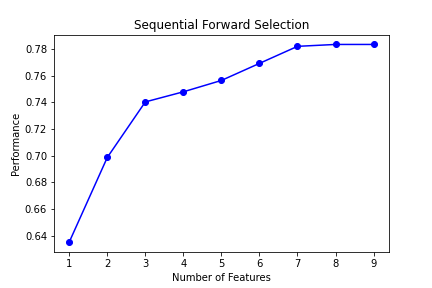

In [327]:
feature_num = [] #stores the number of feature used for each iteration of the sfs algorithm
score=[] #stores the score at each iteration

for key,value in sfs.get_metric_dict().items():
    print(key,value['avg_score'])
    feature_num.append(key)
    score.append(value['avg_score'])

plt.figure(facecolor='w', edgecolor='w')
plt.plot(feature_num,score,marker='o',color='b')
plt.xlabel('Number of Features')
plt.ylabel('Performance')
plt.title('Sequential Forward Selection')
plt.show()
   
    
    
    
    
# plot_sfs(sfs.get_metric_dict())
# plt.title('Sequential Forward Selection')
# plt.show()

fig = plt
fig.savefig('sequential_forward.png',facecolor='w', edgecolor='w',transparent=False) #saves the plot

## Sequential Backward Selection

Sequential forward selection was able to find a feature subset that performed marginally better than the full feature set. Let's use a different sequential method and see how it compares.

Create a sequential backward selection model called `sbs`. 
* Be sure to set the `estimator` parameter to `lr` and set the `forward` and `floating` parameters to the appropriate values.
* Also use the parameters `k_features=7`, `scoring='accuracy'`, and `cv=0`.

In [328]:
sbs = SFS(estimator=lr,forward=False,floating=False,k_features=7,scoring='accuracy',cv=0)

### Fit the model

Use the `.fit()` method on `sbs` to fit the model to `X` and `y`.

In [329]:
sbs.fit(X,y);

### Inspect the results

Now that you've run the sequential backward selection algorithm on the logistic regression model with `X` and `y` you can see what features were chosen and check the model accuracy on the smaller feature set. Print `sbs.subsets_[7]` to inspect the results of sequential backward selection.

In [330]:
print(sbs.subsets_[7])

{'feature_idx': (1, 2, 3, 4, 6, 9, 16), 'cv_scores': array([0.76409285]), 'avg_score': 0.7640928469919469, 'feature_names': ('Age', 'family_history_with_overweight', 'FAVC', 'FCVC', 'CAEC', 'SCC', 'Public_Transportation')}


### Chosen features and model accuracy

Use the dictionary `sbs.subsets_[7]` to print a tuple of chosen feature names. Then use it to print the accuracy of the model after doing sequential backward selection. How does this compare to the model's accuracy on all available features?

In [331]:
print(sbs.subsets_[7]['feature_names'])
sbs_score = sbs.subsets_[7]['avg_score']
print(sbs_score)
print(sbs.subsets_[18]['avg_score'])

('Age', 'family_history_with_overweight', 'FAVC', 'FCVC', 'CAEC', 'SCC', 'Public_Transportation')
0.7640928469919469
0.7659876835622927


### Visualize model accuracy

You can visualize the results of sequential backward floating selection just as you did with sequential forward selection. Use the code `plot_sfs(sbs.get_metric_dict())` to plot the model accuracy as a function of the number of features used.

18 0.7659876835622927
17 0.7674088109900521
16 0.7678825201326386
15 0.7678825201326386
14 0.7674088109900521
13 0.7678825201326386
12 0.7674088109900521
11 0.7674088109900521
10 0.7688299384178114
9 0.7674088109900521
8 0.7659876835622927
7 0.7640928469919469


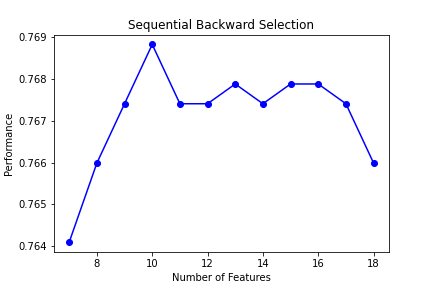

In [332]:
feature_num = [] #stores the number of feature used for each iteration of the sbs algorithm
score=[] #stores the score at each iteration of the sbs algorthm

for key,value in sbs.get_metric_dict().items():
    print(key,value['avg_score'])
    feature_num.append(key)
    score.append(value['avg_score'])

plt.figure(facecolor='w', edgecolor='w')
plt.plot(feature_num,score,marker='o',color='b')
plt.xlabel('Number of Features')
plt.ylabel('Performance')
plt.title('Sequential Backward Selection')
plt.show()

# plot_sfs(sbs.get_metric_dict())
# plt.title('Sequential Backward Selection')
# plt.show()


fig = plt
fig.savefig('sequential_backwards.png',facecolor='w', edgecolor='w',transparent=False) #saves the plot

## Recursive Feature Elimination

So far you've tried two different sequential feature selection methods. Let's try one more: recursive feature elimination. First you'll standardize the data, then you'll fit the RFE model and inspect the results.

At a later step of this project, you'll need to be able to access feature names. Enter the code `features = X.columns` for use later.

In [333]:
Features = X.columns
Features

Index(['Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'FCVC',
       'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC',
       'Automobile', 'Bike', 'Motorbike', 'Public_Transportation', 'Walking'],
      dtype='object')

### Standardize the data

Before doing applying recursive feature elimination it is necessary to standardize the data. Standardize `X` and save it as a DataFrame by creating a `StandardScaler()` object and using the `.fit_transform()` method.

In [334]:
X = StandardScaler().fit_transform(X)

### Recursive feature elimination model

Create an `RFE()` object that selects `8` features. Be sure to set the `estimator` parameter to `lr`.

In [335]:
rfe = RFE(estimator=lr,n_features_to_select=5)

### Fit the model

Fit the recursive feature elimination model to `X` and `y`.

In [336]:
rfe.fit(X,y);
print(rfe.support_)

[False  True  True  True False False  True False False False False False
 False  True False False False False]


### Inspect chosen features

Now that you've fit the RFE model you can evaluate the results. Create a list of chosen feature names and call it `rfe_features`. You can use a list comprehension and filter the features in `zip(features, rfe.support_)` based on whether their support is `True` (meaning the model kept them) or `False` (meaning the model eliminated them).

In [337]:
rfe_features = [f for(f,support) in zip(Features,rfe.support_) if support==True]
rfe_features

['Age', 'family_history_with_overweight', 'FAVC', 'CAEC', 'Automobile']

### Model accuracy

Use the `.score()` method on `rfe` and print the model accuracy after doing recursive feature elimination. How does this compare to the model's accuracy on all available features?

In [338]:
print(rfe.score(X,y))

0.7517764092846992


{1: 0.635243960208432, 2: 0.6882993841781146, 3: 0.7404073898626243, 4: 0.7404073898626243, 5: 0.7517764092846992, 6: 0.757934628138323, 7: 0.7626717195641876, 8: 0.7678825201326386, 9: 0.7621980104216012, 10: 0.7664613927048792, 11: 0.7659876835622927, 12: 0.7669351018474656, 13: 0.7664613927048792, 14: 0.7664613927048792, 15: 0.7659876835622927, 16: 0.7674088109900521, 17: 0.7678825201326386, 18: 0.7678825201326386}
{1: ['family_history_with_overweight'], 2: ['family_history_with_overweight', 'FAVC'], 3: ['family_history_with_overweight', 'FAVC', 'CAEC'], 4: ['Age', 'family_history_with_overweight', 'FAVC', 'CAEC'], 5: ['Age', 'family_history_with_overweight', 'FAVC', 'CAEC', 'Automobile'], 6: ['Age', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SCC', 'Automobile'], 7: ['Age', 'family_history_with_overweight', 'FAVC', 'FCVC', 'CAEC', 'SCC', 'Automobile'], 8: ['Age', 'family_history_with_overweight', 'FAVC', 'FCVC', 'CAEC', 'SCC', 'Automobile', 'Walking'], 9: ['Age', 'family_his

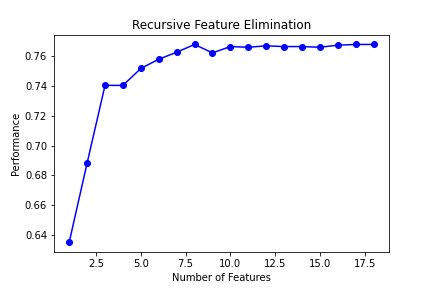

In [339]:
#Getting and plotting the accuracy of RFE over the range of all Features
rfe_nfeature_score={} #dictionary to store the number of features (nfeatures) as keys and scores as values
rfe_nfeature_feature = {} #dictionary to store the number of features (nfeatures) as keys and features as values


for i in range(1,len(Features)+1):
#     print(i)
    rfe = RFE(estimator=lr,n_features_to_select=i)
    rfe.fit(X,y);
    rfe_features = [f for(f,support) in zip(Features,rfe.support_) if support==True]
    rfe_nfeature_score[i] = rfe.score(X,y)
    rfe_nfeature_feature[i] = rfe_features


print(rfe_nfeature_score)
print(rfe_nfeature_feature)



plt.figure(facecolor='w', edgecolor='w')
plt.plot(rfe_nfeature_score.keys(),rfe_nfeature_score.values(),marker='o',color='b')
plt.xlabel('Number of Features')
plt.ylabel('Performance')
plt.title('Recursive Feature Elimination')
plt.show()

fig = plt
fig.savefig('recursive.png',facecolor='w', edgecolor='w',transparent=False) #saves the plot

## Boruta Algorithm

Let's use another type of wrapper method called the Boruta Algorithm, its operation relies on the random forest algorithm.
You will have to create the Random forest model and then pass the model to the `BorutaPy` object

In [340]:
##First, create the Random forest model
RF = RandomForestRegressor(n_estimators=100,max_depth=5,random_state=42)
RF.fit(X,y);

In [341]:
#Next, create the Boruta object
bor = BorutaPy(estimator=RF, n_estimators= 'auto',verbose=2,max_iter=10)

### Fit the model

Fit the Boruta model to `X` and `y`.

In [342]:
bor.fit(np.array(X),np.array(y));

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	9
Tentative: 	2
Rejected: 	7
Iteration: 	9 / 10
Confirmed: 	9
Tentative: 	2
Rejected: 	7


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	1
Rejected: 	7


### Inspect chosen features

Now that you've fit the Boruta model you can evaluate the results. Create a list of chosen feature names and call it `bor_features`. You can use a list comprehension and filter the features in `zip(features, bor.support_)` based on whether their support is `True` (meaning the model kept them) or `False` (meaning the model eliminated them).

Hint: `[f for (f, support) in zip(features, bor.support_) if support]` will produce the desired list of feature names.

In [343]:
# See which features Boruta chose
bor_features = [f for (f,support) in zip(Features, bor.support_) if support]
print(Features)
print(bor.ranking_)
print(bor_features)

Index(['Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'FCVC',
       'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC',
       'Automobile', 'Bike', 'Motorbike', 'Public_Transportation', 'Walking'],
      dtype='object')
[ 3  1  1  1  1  1  1  5  1  8  1  1  4  5 10  7  2  9]
['Age', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE']


In [344]:
#group the features from each feature selection method into a set
set1 = set(sfs.subsets_[7]['feature_names'])
set2 = set(sbs.subsets_[10]['feature_names'])
set3 = set(rfe_features)
set4 = set(bor_features)

#find the intersection between these sets
intersection_set = set1 & set2 & set3 & set4

final_features = list(intersection_set)
print(final_features)


['family_history_with_overweight', 'FAVC', 'CAEC', 'Age']


In [345]:
#Retrain the logistic and Random Forest regressor on the 4 features above
#redefine the predictor variable
y_new= obesity['NObeyesdad']
X_new = obesity[bor_features]


#create the new logistic regression model
lr_new = LogisticRegression(max_iter=1000)
#fit the X,y to the model
lr_new.fit(X_new,y_new)
print(f'This new logistic model trained on 4 features accurately predicted {round(100*lr_new.score(X_new,y_new),3)}% \
of respondents as obese while the original trained on 18 features predicted {round(100*org_score,3)}%') 


This new logistic model trained on 4 features accurately predicted 74.846% of respondents as obese while the original trained on 18 features predicted 76.599%
